In [1]:
!pip install owlready2 spacy matplotlib
!python -m spacy download en_core_web_sm
!pip install fuzzywuzzy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 44.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp310-cp310-linux_x86_64.whl size=24075195 sha256=1b4477994ef82a002c900453ab2abda3f8dd2c2429657267c10b5b291cbd5897
  Stored in directory: /root/.cache/pip/wheels/27/3e/ba/4171c4b10bba9fe1774fbf8fcf794de889e636ce64ad83a533
Successfully built owlready2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import os
from owlready2 import get_ontology, class_construct, sync_reasoner,sync_reasoner_pellet
import spacy
import re
from fuzzywuzzy import process
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Load ontology
ontology_path = "EmotionOntology.owl"
ontology = get_ontology(ontology_path).load()
sync_reasoner_pellet(infer_property_values=True)

# Explore ontology classes and relationships
print("Ontology Classes:")
for cls in ontology.classes():
    print(cls)

print("\nOntology Relationships:")
for rel in ontology.object_properties():
    print(rel)

* Owlready2 * Running Pellet...
    java -Xmx2000M -cp /usr/local/lib/python3.10/dist-packages/owlready2/pellet/owlapi-distribution-3.4.3-bin.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/pellet-2.3.1.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/antlr-3.2.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/log4j-1.2-api-2.19.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jena-arq-2.10.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/aterm-java-1.6.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jcl-over-slf4j-1.6.4.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/jena-iri-0.9.5.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/log4j-core-2.19.0.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/httpcore-4.2.2.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/antlr-runtime-3.2.jar:/usr/local/lib/python3.10/dist-packages/owlready2/pellet/httpclient-4.2.3.jar:/usr

Ontology Classes:
EmotionOntology.Abyss
EmotionOntology.Acceptance
EmotionOntology.Achievement
EmotionOntology.Admiration
EmotionOntology.Affection
EmotionOntology.Aggressive
EmotionOntology.AlertPosture
EmotionOntology.Amazement
EmotionOntology.Anchor
EmotionOntology.Anger
EmotionOntology.Annoyance
EmotionOntology.Anticipation
EmotionOntology.Applause
EmotionOntology.Apprehention
EmotionOntology.Ashes
EmotionOntology.Await
EmotionOntology.Awe
EmotionOntology.BasicEmotion
EmotionOntology.Betrayal
EmotionOntology.BitterSmile
EmotionOntology.Bittersweet
EmotionOntology.BlackHeart
EmotionOntology.Blaze
EmotionOntology.Bliss
EmotionOntology.Bloom
EmotionOntology.Blooming
EmotionOntology.BloomingFlower
EmotionOntology.BlueSky
EmotionOntology.Bluebird
EmotionOntology.Bond
EmotionOntology.Boredom
EmotionOntology.BoundWrist
EmotionOntology.BowedHead
EmotionOntology.Breath
EmotionOntology.Breeze
EmotionOntology.Bridge
EmotionOntology.BrightFuture
EmotionOntology.BrightPath
EmotionOntology.Broke

* Owlready2 * Pellet took 6.226895809173584 seconds
* Owlready * (NB: only changes on entities loaded in Python are shown, other changes are done but not listed)


In [10]:


# Load spaCy NLP model
nlp = spacy.load("en_core_web_sm")

def preprocess_text(text, n=3):
    """
    Preprocess text to generate tokens and n-grams, preserving multi-word tokens.
    """
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    # Include only n-grams relevant to ontology terms
    ngrams = []
    for i in range(1, n + 1):
        ngrams.extend([' '.join(tokens[j:j + i]) for j in range(len(tokens) - i + 1)])

    return tokens + ngrams

def normalize_class_name(class_name):
    """
    Normalize ontology class names into lowercase words separated by spaces.
    Example: 'WiltedRose' -> 'wilted rose'
    """
    return re.sub(r'(?<!^)(?=[A-Z])', ' ', class_name).lower()

def categorize_match(cls, matches):
    """
    Categorize matched classes into appropriate categories.
    """
    superclasses = [ancestor.name for ancestor in cls.ancestors()]
    if "Emotion" in superclasses:
        matches["emotions"].append(cls)
    elif "Symbol" in superclasses:
        matches["symbols"].append(cls)
    elif "Cause" in superclasses:
        matches["causes"].append(cls)

def match_to_ontology(tokens, ontology):
    """
    Match tokens to ontology concepts using exact and fuzzy matching, ensuring multi-word matches.
    """
    matches = {"emotions": [], "symbols": [], "causes": []}
    class_name_map = {normalize_class_name(cls.name): cls for cls in ontology.classes()}
    exact_matches_found = set()

    # Exact matching
    for token in tokens:
        for norm_name, cls in class_name_map.items():
            if token in norm_name:
                categorize_match(cls, matches)
                exact_matches_found.add(norm_name)

    # Fuzzy matching
    for token in tokens:
        best_match, score = process.extractOne(token, class_name_map.keys())
        if score >= 90 and best_match not in exact_matches_found:
            categorize_match(class_name_map[best_match], matches)

    return matches

def extract_items(association):
    """
    Extract items from relationships.
    Handles cases with AND constructs, lists, or single objects.
    """
    items = []

    if isinstance(association, class_construct.And):  # Logical AND
        for cls in association.Classes:
            items.extend(extract_items(cls))
    elif isinstance(association, list):  # List of associations
        for item in association:
            items.extend(extract_items(item))
    elif association:  # Single item
        items.append(clean_iri(association))

    return sorted(set(items))  # Deduplicate and sort

def enrich_emotions(matches, ontology):
    """
    Enrich detected emotions with relationships (symbols, causes, intensities, polarities, composition).
    """
    enriched_data = {"emotions": {}, "symbols": matches["symbols"], "causes": matches["causes"]}

    for emotion in matches["emotions"]:
        name = clean_iri(emotion)
        enriched_data["emotions"][name] = {
            "symbols": [],
            "causes": [],
            "symbol_counts": 0,  # Initialize symbol count
            "cause_counts": 0,   # Initialize cause count
            "intensity": None,
            "polarity": None,
            "opposite": None,
            "composed_of": []
        }

        # Check if the emotion is a ComplexEmotion
        if "ComplexEmotion" in [ancestor.name for ancestor in emotion.ancestors()]:
            # Complex emotions: symbols, causes, polarity, composed_of
            associated_symbols = getattr(emotion, "isAssociatedWith", [])
            associated_causes = getattr(emotion, "hasCause", [])
            polarity = getattr(emotion, "hasPolarity", [])
            composed_of = getattr(emotion, "isComposedOf", [])

            enriched_data["emotions"][name]["symbols"].extend(extract_items(associated_symbols))
            enriched_data["emotions"][name]["causes"].extend(extract_items(associated_causes))
            enriched_data["emotions"][name]["polarity"] = clean_iri(polarity[0]) if polarity else None
            enriched_data["emotions"][name]["composed_of"].extend(extract_items(composed_of))

        else:
            # Non-complex emotions: symbols, causes, intensity, polarity, opposite
            associated_symbols = getattr(emotion, "isAssociatedWith", [])
            associated_causes = getattr(emotion, "hasCause", [])
            intensity = getattr(emotion, "hasIntensity", [])
            polarity = getattr(emotion, "hasPolarity", [])
            opposite = getattr(emotion, "isOpositeOf", [])

            enriched_data["emotions"][name]["symbols"].extend(extract_items(associated_symbols))
            enriched_data["emotions"][name]["causes"].extend(extract_items(associated_causes))
            enriched_data["emotions"][name]["intensity"] = clean_iri(intensity[0]) if intensity else None
            enriched_data["emotions"][name]["polarity"] = clean_iri(polarity[0]) if polarity else None
            enriched_data["emotions"][name]["opposite"] = clean_iri(opposite[0]) if opposite else None


    return enriched_data

def clean_iri(iri):
    """
    Clean ontology IRIs or ThingClass objects for better readability.
    """
    iri = str(iri)  # Convert to string if it's an ontology object
    return iri.split('.')[-1].replace("]", "").strip()  # Remove any brackets and unwanted characters

def add_new_emotion(new_emotions, emotion, symbol=None, cause=None):
    """Add new inferred emotions."""
    name = clean_iri(emotion)
    if name not in new_emotions:
        new_emotions[name] = {
            "symbols": [],
            "causes": [],
            "intensity": None,
            "polarity": None,
            "opposite": None,
            "composed_of": []
        }

    # Add symbols and causes if provided
    if symbol:
        new_emotions[name]["symbols"].append(symbol)
    if cause:
        new_emotions[name]["causes"].append(cause)

    # Retrieve other relationships dynamically
    polarity = extract_items(getattr(emotion, "hasPolarity", []))
    if polarity:
        new_emotions[name]["polarity"] = clean_iri(polarity[0]) if polarity else None

    intensity = extract_items(getattr(emotion, "hasIntensity", []))
    if intensity:
        new_emotions[name]["intensity"] = clean_iri(intensity[0]) if intensity else None

    opposite = extract_items(getattr(emotion, "isOpositeOf", []))
    if opposite:
        new_emotions[name]["opposite"] = clean_iri(opposite[0]) if opposite else None

    composed_of = extract_items(getattr(emotion, "isComposedOf", []))
    if composed_of:
        new_emotions[name]["composed_of"].extend(composed_of)


def infer_new_emotions(enriched_data, ontology):
    """
    Infer new emotions based on discovered symbols and causes, ensuring relationships are fully retrieved.
    """
    new_emotions = {}

    # Iterate over all emotions in the ontology
    for emotion in ontology.classes():
        if "Emotion" in [ancestor.name for ancestor in emotion.ancestors()]:
            name = clean_iri(emotion)

            # Extract associated symbols and causes
            associated_symbols = extract_items(getattr(emotion, "isAssociatedWith", []))
            associated_causes = extract_items(getattr(emotion, "hasCause", []))

            # Check if detected symbols or causes match this emotion
            matched_symbols = [symbol for symbol in enriched_data["symbols"] if symbol in associated_symbols]
            matched_causes = [cause for cause in enriched_data["causes"] if cause in associated_causes]

            if matched_symbols or matched_causes:
                # Add a new inferred emotion or enrich an existing one
                add_new_emotion(new_emotions, emotion)
                new_emotions[name]["symbols"].extend(matched_symbols)
                new_emotions[name]["causes"].extend(matched_causes)

                # Retrieve additional relationships dynamically
                polarity = extract_items(getattr(emotion, "hasPolarity", []))
                if polarity:
                    new_emotions[name]["polarity"] = clean_iri(polarity[0]) if polarity else None

                intensity = extract_items(getattr(emotion, "hasIntensity", []))
                if intensity:
                    new_emotions[name]["intensity"] = clean_iri(intensity[0]) if intensity else None

                opposite = extract_items(getattr(emotion, "isOpositeOf", []))
                if opposite:
                    new_emotions[name]["opposite"] = clean_iri(opposite[0]) if opposite else None

                if "ComplexEmotion" in [ancestor.name for ancestor in emotion.ancestors()]:
                    composed_of = extract_items(getattr(emotion, "isComposedOf", []))
                    if composed_of:
                        new_emotions[name]["composed_of"].extend(composed_of)

    return new_emotions


def recheck_symbols_and_causes(enriched_data, ontology):
    """
    Recheck detected symbols and causes against the ontology to find additional emotions.
    """
    unmatched_symbols = detect_unmatched_symbols_with_fuzzy_logic(
    all_symbols=enriched_data["symbols"],
    detected_symbols=sum([details["symbols"] for details in enriched_data["emotions"].values()], [])
)

    unmatched_causes = detect_unmatched_symbols_with_fuzzy_logic(
        all_symbols=enriched_data["causes"],
        detected_symbols=sum([details["causes"] for details in enriched_data["emotions"].values()], [])
    )

    for emotion in ontology.classes():
        if "Emotion" in [ancestor.name for ancestor in emotion.ancestors()]:
            name = clean_iri(emotion)

            # Extract relationships
            associated_symbols = extract_items(getattr(emotion, "isAssociatedWith", []))
            associated_causes = extract_items(getattr(emotion, "hasCause", []))

            # Check for unmatched symbols or causes
            matched_symbols = [symbol for symbol in unmatched_symbols if symbol in associated_symbols]
            matched_causes = [cause for cause in unmatched_causes  if cause in associated_causes]

            if matched_symbols or matched_causes:
                if name not in enriched_data["emotions"]:
                    enriched_data["emotions"][name] = {
                        "symbols": matched_symbols,
                        "causes": matched_causes,
                        "intensity": None,
                        "polarity": None,
                        "opposite": None,
                        "composed_of": []
                    }

                # Retrieve additional relationships dynamically
                polarity = extract_items(getattr(emotion, "hasPolarity", []))
                if polarity:
                    enriched_data["emotions"][name]["polarity"] = clean_iri(polarity[0]) if polarity else None

                intensity = extract_items(getattr(emotion, "hasIntensity", []))
                if intensity:
                    enriched_data["emotions"][name]["intensity"] = clean_iri(intensity[0]) if intensity else None

                opposite = extract_items(getattr(emotion, "isOpositeOf", []))
                if opposite:
                    enriched_data["emotions"][name]["opposite"] = clean_iri(opposite[0]) if opposite else None

                if "ComplexEmotion" in [ancestor.name for ancestor in emotion.ancestors()]:
                    composed_of = extract_items(getattr(emotion, "isComposedOf", []))
                    if composed_of:
                        enriched_data["emotions"][name]["composed_of"].extend(composed_of)


def calculate_emotion_contributions(enriched_data, tokens):
    """
    Calculate weighted contributions of each emotion based on symbol and cause frequencies,
    considering normalization, IRI cleaning, and fuzzy matching with process.extractOne.
    """
    contributions = {}
    intensity_weights = {"Low": 0.5, "Normal": 1, "High": 1.5}

    # Normalize tokens for matching
    normalized_tokens = [normalize_class_name(token) for token in tokens]

    for emotion, details in enriched_data["emotions"].items():
        symbol_count = 0
        cause_count = 0

        # Match symbols in the text
        for symbol in details["symbols"]:
            clean_symbol = normalize_class_name(clean_iri(symbol))
            best_match, score = process.extractOne(clean_symbol, normalized_tokens)
            if score >= 90:
                symbol_count += 1

        # Match causes in the text
        for cause in details["causes"]:
            clean_cause = normalize_class_name(clean_iri(cause))
            best_match, score = process.extractOne(clean_cause, normalized_tokens)
            if score >= 90:
                cause_count += 1

        # Update counts in the enriched data
        details["symbol_counts"] = symbol_count
        details["cause_counts"] = cause_count

        # Calculate weighted contribution
        intensity_weight = intensity_weights.get(details["intensity"], 1)
        contribution = (symbol_count + cause_count) * intensity_weight
        contributions[emotion] = contribution

    return contributions


def detect_unmatched_symbols_with_fuzzy_logic(all_symbols, detected_symbols):
    """
    Detect unmatched symbols using fuzzy logic.
    """
    unmatched_symbols = []
    normalized_detected = [normalize_class_name(s) for s in detected_symbols]  # Normalize detected symbols

    for symbol in all_symbols:
        # Normalize symbol
        clean_symbol = normalize_class_name(clean_iri(symbol))

        # Check if detected_symbols is not empty before calling extractOne
        if normalized_detected:
            best_match, score = process.extractOne(clean_symbol, normalized_detected)
            # Consider it unmatched if no close match is found
            if not best_match or score < 90:  # Adjust threshold as needed
                unmatched_symbols.append(symbol)
        else:
            unmatched_symbols.append(symbol)  # If no detected symbols, all are unmatched

    return unmatched_symbols



def visualize_analysis_with_sentiment(result,text, tokens):
    """
    Display the analysis results in a structured format.
    """

    # Display the text content before the analysis results
    print("\n--- Input Text ---\n")
    print(text)


    # Calculate contributions
    contributions = calculate_emotion_contributions(result, tokens)
    total_weighted_sentiment = 0
    total_weight = sum(contributions.values())


    print("\nDetected Emotions and Details:")
    for emotion, details in result["emotions"].items():
      # Retrieve polarity score
        polarity_score = {"Positive": 1, "Neutral": 0, "Negative": -1}.get(details["polarity"], 0)

        # Calculate weighted sentiment
        weighted_sentiment = contributions[emotion] * polarity_score
        total_weighted_sentiment += weighted_sentiment


        print(f"  - {emotion}")
        print(f"    - Symbols: {', '.join(details['symbols']) if details['symbols'] else 'None'}")
        print(f"    - Causes: {', '.join(details['causes']) if details['causes'] else 'None'}")
        print(f"    - Polarity: {details['polarity'] if details['polarity'] else 'None'}")


        # Check for 'composed_of' key to handle Complex Emotions safely
        if "composed_of" in details and details["composed_of"]:
            print(f"    - Composed Of: {', '.join(details['composed_of'])}")

        else:
            print(f"    - Intensity: {details['intensity'] if details['intensity'] else 'None'}")
            print(f"    - Opposite Emotion: {details['opposite'] if details['opposite'] else 'None'}")

    print("\nOther Symbols and Causes Detected:")
    cleaned_symbols = [clean_iri(symbol) for symbol in result["symbols"]]
    print(f"  Symbols: {', '.join(cleaned_symbols) if cleaned_symbols else 'None'}")
    cleaned_causes = [clean_iri(cause) for cause in result["causes"]]
    print(f"  Causes: {', '.join(cleaned_causes) if cleaned_causes else 'None'}")

    print("\nUnmatched Symbols and Causes Detected:")
    unmatched_symbols = [symbol for symbol in result["symbols"] if symbol not in sum([details["symbols"] for details in result["emotions"].values()], [])]
    unmatched_causes = [cause for cause in result["causes"] if cause not in sum([details["causes"] for details in result["emotions"].values()], [])]

    print(f"  Unmatched Symbols: {', '.join(unmatched_symbols) if unmatched_symbols else 'None'}")
    print(f"  Unmatched Causes: {', '.join(unmatched_causes) if unmatched_causes else 'None'}")

    # Plot pie chart for emotion contributions
    plt.figure(figsize=(8, 8))
    plt.pie(contributions.values(), labels=contributions.keys(), autopct='%1.1f%%', startangle=140)
    plt.title("Emotion Contribution Distribution")
    plt.show()

    # Calculate and display overall sentiment score
    overall_sentiment = total_weighted_sentiment / total_weight if total_weight > 0 else 0
    print(f"\nOverall Sentiment Score: {overall_sentiment:.2f} (Positive: > 0, Neutral: 0, Negative: < 0)")



def deduplicate_list(items):
    """
    Remove duplicates from a list and clean items.
    Converts ontology objects (ThingClass) to readable strings.
    """
    cleaned_items = [clean_iri(item) for item in items]
    return sorted(set(cleaned_items))

def analyze_file(file_path, ontology):
    """Analyze the input text file."""
    with open(file_path, "r", encoding="utf-8") as file:
        text = file.read()

    tokens = preprocess_text(text)
    matches = match_to_ontology(tokens, ontology)

    # Deduplicate symbols and causes
    matches["symbols"] = deduplicate_list(matches["symbols"])
    matches["causes"] = deduplicate_list(matches["causes"])

    # Enrich detected emotions
    enriched_data = enrich_emotions(matches, ontology)

    # Infer new emotions based on discovered symbols and causes
    inferred_emotions = infer_new_emotions(enriched_data, ontology)

    # Recheck symbols and causes for missing emotions
    recheck_symbols_and_causes(enriched_data, ontology)


    # Merge inferred emotions into enriched emotions
    for emotion, details in inferred_emotions.items():
        if emotion not in enriched_data["emotions"]:
            enriched_data["emotions"][emotion] = details
        else:
            # Merge without duplication
            enriched_data["emotions"][emotion]["symbols"] = sorted(
                set(enriched_data["emotions"][emotion]["symbols"] + details["symbols"])
            )
            enriched_data["emotions"][emotion]["causes"] = sorted(
                set(enriched_data["emotions"][emotion]["causes"] + details["causes"])
            )
            enriched_data["emotions"][emotion]["composed_of"] = sorted(
                set(enriched_data["emotions"][emotion]["composed_of"] + details["composed_of"])
            )


    # Pass enriched data and tokens to visualization
    visualize_analysis_with_sentiment(enriched_data, text, tokens)


    return enriched_data





--- Input Text ---

Time does not bring relief; you all have lied   
Who told me time would ease me of my pain!   
I miss him in the weeping of the rain;   
I want him at the shrinking of the tide;
The old snows melt from every mountain-side,   
And last year’s leaves are smoke in every lane;   
But last year’s bitter loving must remain
Heaped on my heart, and my old thoughts abide.   
There are a hundred places where I fear   
To go,—so with his memory they brim.   
And entering with relief some quiet place   
Where never fell his foot or shone his face   
I say, “There is no memory of him here!”   
And so stand stricken, so remembering him.

Detected Emotions and Details:
  - Submission
    - Symbols: BoundWrist, BowedHead, Chains, ClosedDoor, DarkenedRoom, DistantLook, EmptyHands, Fog, FoldedHands, HeavyHeart, KneelingFigure, LowHorizon, QuietTear, ShadowedFace, SilentGaze, StifledBreath, StillWater, Weight
    - Causes: Conflict, Injustice
    - Polarity: Neutral
    - Composed Of

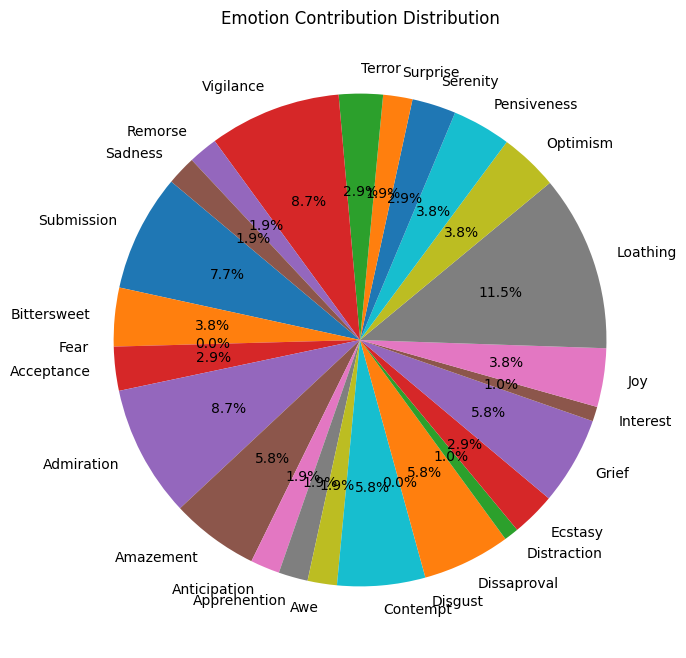


Overall Sentiment Score: -0.09 (Positive: > 0, Neutral: 0, Negative: < 0)


In [17]:

folder = "Poetry"
file_name = "poetry10.txt"
file_path = os.path.join(folder, file_name)

if os.path.exists(file_path):
    # Read the text file
    with open(file_path, "r", encoding="utf-8") as file:
        text_content = file.read()

    # Analyze the file
    analyze_file(file_path, ontology)


    # Visualize the analysis results
    #visualize_analysis(result)
else:
    print(f"File not found: {file_path}")